In [1]:

import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd


from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


import matplotlib.pyplot as plt

In [2]:
N_STEPS = 7


LOOKUP_STEPS = [1, 2, 3]

 
STOCK = 'THYAO.IS'


date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [3]:
init_df = yf.get_data(
    STOCK, 
    start_date=date_3_years_back, 
    end_date=date_now, 
    interval='1d')

In [4]:
df = pd.DataFrame(init_df)
init_df = df.dropna()
init_df


,open,high,low,close,adjclose,volume,ticker
2020-07-27,11.850000,11.850000,11.580000,11.600000,11.600000,43836986,THYAO.IS
2020-07-28,11.590000,11.610000,11.030000,11.080000,11.080000,52529268,THYAO.IS
2020-07-29,11.060000,11.150000,10.720000,10.830000,10.830000,59119889,THYAO.IS
2020-07-30,10.800000,10.850000,10.650000,10.690000,10.690000,21929029,THYAO.IS
2020-08-04,10.700000,11.280000,10.490000,11.000000,11.000000,112929169,THYAO.IS
...,...,...,...,...,...,...,...
2023-07-27,225.000000,228.699997,222.500000,228.500000,228.500000,41664031,THYAO.IS
2023-07-28,229.199997,237.600006,228.399994,235.000000,235.000000,52651752,THYAO.IS
2023-07-31,235.800003,236.600006,232.600006,234.300003,234.300003,39359023,THYAO.IS
2023-08-01,232.399994,235.100006,230.699997,231.000000,231.000000,28560161,THYAO.IS


In [5]:
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)

init_df['date'] = init_df.index

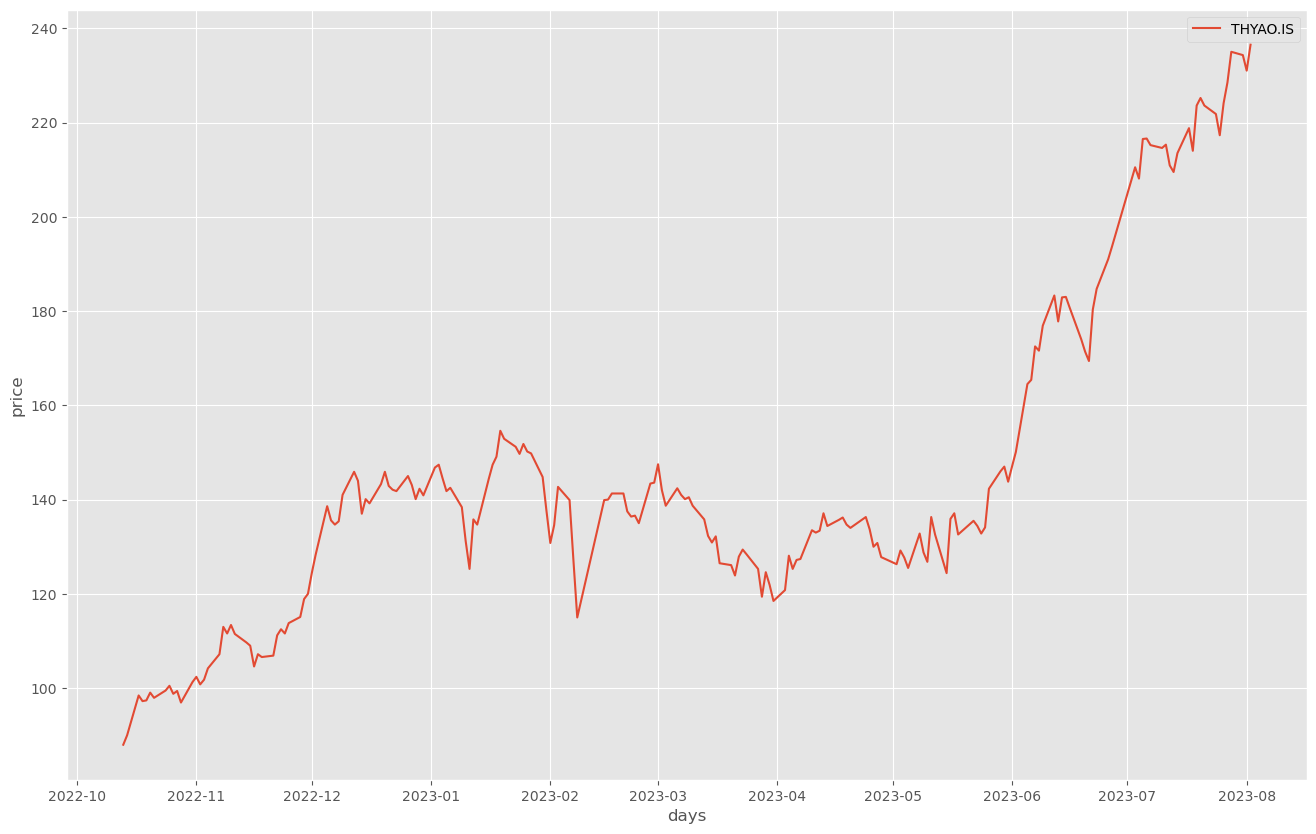

In [6]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'{STOCK}'])
plt.show()

In [7]:
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
init_df

,close,date,scaled_close
2020-07-27,11.600000,2020-07-27,0.011342
2020-07-28,11.080000,2020-07-28,0.009056
2020-07-29,10.830000,2020-07-29,0.007957
2020-07-30,10.690000,2020-07-30,0.007341
2020-08-04,11.000000,2020-08-04,0.008704
...,...,...,...
2023-07-27,228.500000,2023-07-27,0.964832
2023-07-28,235.000000,2023-07-28,0.993406
2023-07-31,234.300003,2023-07-31,0.990329
2023-08-01,231.000000,2023-08-01,0.975822


In [8]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)


  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)


  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y
PrepareData(3)

(                 close       date  scaled_close    future
 2020-07-27   11.600000 2020-07-27      0.011342  0.007341
 2020-07-28   11.080000 2020-07-28      0.009056  0.008704
 2020-07-29   10.830000 2020-07-29      0.007957  0.008045
 2020-07-30   10.690000 2020-07-30      0.007341  0.005275
 2020-08-04   11.000000 2020-08-04      0.008704  0.007429
 ...                ...        ...           ...       ...
 2023-07-24  221.800003 2023-07-24      0.935379  0.964832
 2023-07-25  217.300003 2023-07-25      0.915597  0.993406
 2023-07-26  224.100006 2023-07-26      0.945490  0.990329
 2023-07-27  228.500000 2023-07-27      0.964832  0.975822
 2023-07-28  235.000000 2023-07-28      0.993406  1.000000
 
 [752 rows x 4 columns],
 array([[0.9503253 ],
        [0.9432917 ],
        [0.93537897],
        [0.91559696],
        [0.94548976],
        [0.96483207],
        [0.993406  ],
        [0.99032885],
        [0.97582203],
        [1.        ]], dtype=float32),
 array([[[0.0113416560967902

In [9]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [10]:
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
94/94 [==============================] - 6s 11ms/step - loss: 0.0094
Epoch 2/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0018
Epoch 3/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0013
Epoch 4/80
94/94 [==============================] - 1s 12ms/step - loss: 0.0014
Epoch 5/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0017
Epoch 6/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 7/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 8/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0014
Epoch 9/80
94/94 [==============================] - 1s 10ms/step - loss: 9.4564e-04
Epoch 10/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0012
Epoch 11/80
94/94 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 12/80
94/94 [==============================] - 1s 10ms/step - loss: 0.0011
Epoch 13/80
94/94 [==============

In [11]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'tl' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} 3 GÜNLÜK TAHMİNİ ({predictions_str})'
  
  print(message)

THYAO.IS 3 GÜNLÜK TAHMİNİ (236.55tl, 226.24tl, 234.41tl)


In [12]:
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 7ms/step


In [13]:
copy_df

,close,date,scaled_close,predicted_close
2020-07-27,11.600000,2020-07-27,0.011342,11.610000
2020-07-28,11.080000,2020-07-28,0.009056,11.510000
2020-07-29,10.830000,2020-07-29,0.007957,11.180000
2020-07-30,10.690000,2020-07-30,0.007341,11.130000
2020-08-04,11.000000,2020-08-04,0.008704,10.960000
...,...,...,...,...
2023-07-27,228.500000,2023-07-27,0.964832,225.507645
2023-07-28,235.000000,2023-07-28,0.993406,229.307892
2023-07-31,234.300003,2023-07-31,0.990329,234.300003
2023-08-01,231.000000,2023-08-01,0.975822,231.000000


In [14]:
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

c:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:3629: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)


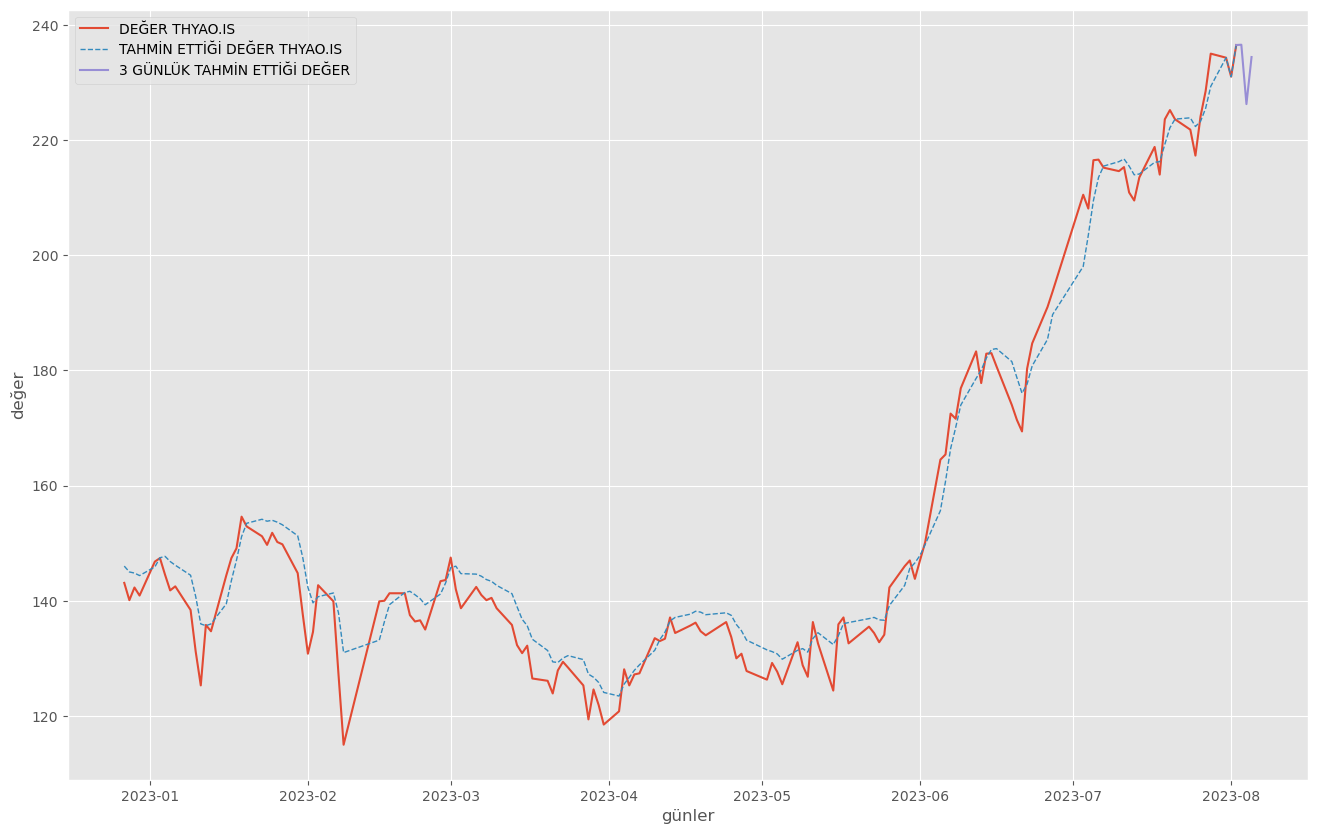

In [15]:
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('günler')
plt.ylabel('değer')
plt.legend([f'DEĞER {STOCK}', 
            f'TAHMİN ETTİĞİ DEĞER {STOCK}',
            f'3 GÜNLÜK TAHMİN ETTİĞİ DEĞER'])
plt.show()